In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

/usr/local/lib/python3.5/dist-packages/xgboost/__init__.py:29: FutureWarning: Python 3.5 support is deprecated; XGBoost will require Python 3.6+ in the near future. Consider upgrading to Python 3.6+.
  FutureWarning)


In [2]:
import sys, os
sys.path.append(os.path.join(os.path.dirname('Demand'), '..', 'src'))
from Demand_class import Demand

In [3]:
path = '../data/demand_lower_48'

In [4]:
nat_dem = Demand()

In [5]:
nat_dem.load_data(path)

In [7]:
nat_dem.create_time_featues()

In [8]:
nat_dem.create_trig_df()

In [9]:
df = nat_dem.trig_df

In [10]:
df.head()

,Time,Megawatthours,sin_day,cos_day,sin_month,cos_month
0,2015-07-01 02:00:00,335153,0.500000,8.660254e-01,0.030816,-0.999525
1,2015-07-01 03:00:00,333837,0.707107,7.071068e-01,0.030100,-0.999547
2,2015-07-01 04:00:00,398386,0.866025,5.000000e-01,0.029383,-0.999568
3,2015-07-01 05:00:00,388954,0.965926,2.588190e-01,0.028667,-0.999589
4,2015-07-01 06:00:00,392487,1.000000,6.123234e-17,0.027950,-0.999609


In [11]:
df_2 = nat_dem.time_features_df

In [12]:
df_2.head()

,Time,Megawatthours,Year,Month,Hour,Day_of_week,Day_of_month,Day_of_year
0,2015-07-01 02:00:00,335153,2015,7,2,2,1,182
1,2015-07-01 03:00:00,333837,2015,7,3,2,1,182
2,2015-07-01 04:00:00,398386,2015,7,4,2,1,182
3,2015-07-01 05:00:00,388954,2015,7,5,2,1,182
4,2015-07-01 06:00:00,392487,2015,7,6,2,1,182


In [16]:
df_total = pd.concat([df, df_2[['Year', 'Day_of_year']]], axis=1)

In [17]:
df_total

,Time,Megawatthours,sin_day,cos_day,sin_month,cos_month,Year,Day_of_year
0,2015-07-01 02:00:00,335153,5.000000e-01,8.660254e-01,0.030816,-0.999525,2015,182
1,2015-07-01 03:00:00,333837,7.071068e-01,7.071068e-01,0.030100,-0.999547,2015,182
2,2015-07-01 04:00:00,398386,8.660254e-01,5.000000e-01,0.029383,-0.999568,2015,182
3,2015-07-01 05:00:00,388954,9.659258e-01,2.588190e-01,0.028667,-0.999589,2015,182
4,2015-07-01 06:00:00,392487,1.000000e+00,6.123234e-17,0.027950,-0.999609,2015,182
5,2015-07-01 07:00:00,404647,9.659258e-01,-2.588190e-01,0.027234,-0.999629,2015,182
6,2015-07-01 08:00:00,422227,8.660254e-01,-5.000000e-01,0.026517,-0.999648,2015,182
7,2015-07-01 09:00:00,442131,7.071068e-01,-7.071068e-01,0.025801,-0.999667,2015,182
8,2015-07-01 10:00:00,464371,5.000000e-01,-8.660254e-01,0.025084,-0.999685,2015,182
9,2015-07-01 11:00:00,491512,2.588190e-01,-9.659258e-01,0.024368,-0.999703,2015,182


In [19]:
X, y = nat_dem.split_X_y(df_total)

In [20]:
X

,sin_day,cos_day,sin_month,cos_month,Year,Day_of_year
Time,,,,,,
2015-07-01 02:00:00,5.000000e-01,8.660254e-01,0.030816,-0.999525,2015,182
2015-07-01 03:00:00,7.071068e-01,7.071068e-01,0.030100,-0.999547,2015,182
2015-07-01 04:00:00,8.660254e-01,5.000000e-01,0.029383,-0.999568,2015,182
2015-07-01 05:00:00,9.659258e-01,2.588190e-01,0.028667,-0.999589,2015,182
2015-07-01 06:00:00,1.000000e+00,6.123234e-17,0.027950,-0.999609,2015,182
2015-07-01 07:00:00,9.659258e-01,-2.588190e-01,0.027234,-0.999629,2015,182
2015-07-01 08:00:00,8.660254e-01,-5.000000e-01,0.026517,-0.999648,2015,182
2015-07-01 09:00:00,7.071068e-01,-7.071068e-01,0.025801,-0.999667,2015,182
2015-07-01 10:00:00,5.000000e-01,-8.660254e-01,0.025084,-0.999685,2015,182


In [21]:
y

Time
2015-07-01 02:00:00    335153
2015-07-01 03:00:00    333837
2015-07-01 04:00:00    398386
2015-07-01 05:00:00    388954
2015-07-01 06:00:00    392487
2015-07-01 07:00:00    404647
2015-07-01 08:00:00    422227
2015-07-01 09:00:00    442131
2015-07-01 10:00:00    464371
2015-07-01 11:00:00    491512
2015-07-01 12:00:00    518043
2015-07-01 13:00:00    540514
2015-07-01 14:00:00    560701
2015-07-01 15:00:00    576400
2015-07-01 16:00:00    587405
2015-07-01 17:00:00    594477
2015-07-01 18:00:00    595242
2015-07-01 19:00:00    586317
2015-07-01 20:00:00    572656
2015-07-01 21:00:00    554682
2015-07-01 22:00:00    543332
2015-07-01 23:00:00    520871
2015-07-02 00:00:00    485722
2015-07-02 01:00:00    453284
2015-07-02 02:00:00    429199
2015-07-02 03:00:00    407007
2015-07-02 04:00:00    395194
2015-07-02 05:00:00    387654
2015-07-02 06:00:00    390157
2015-07-02 07:00:00    401643
                        ...  
2021-03-20 15:00:00    377793
2021-03-20 16:00:00    371070
2021-

In [22]:
def train_test(X, y, split):
    if isinstance(split, str):
        idx = X.index.get_loc(split)
    else:
        idx = split
    X_train, X_test = X.iloc[:idx], X.iloc[idx:]
    y_train, y_test = y.iloc[:idx], y.iloc[idx:]
    return X_train, X_test, y_train, y_test 


In [23]:
split = '2020-03-01 00:00:00'

In [24]:
X_train, X_test, y_train, y_test = train_test(X, y, split)

In [26]:
xgb_initial = XGBRegressor()

In [28]:
xgb_initial.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [29]:
preds_initial = xgb_initial.predict(X_test)

In [31]:
preds_init_series = pd.Series(preds_initial, index=y_test.index)

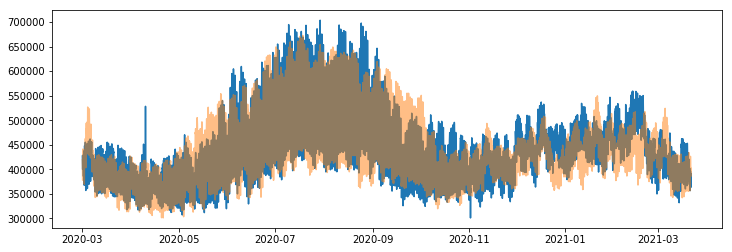

In [33]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(y_test.index, y_test)
ax.plot(y_test.index, preds_init_series, alpha=0.5)

plt.show()

In [34]:
xgb_grid = {'learning_rate': [.01, .1, .2],
                'max_depth': [2, 4, 8],
                'min_samples_leaf': [2, 4], 
                'max_features': ['sqrt', 'log2'],
                'n_estimators': [500, 1000, 1500]}

In [35]:
tscv = TimeSeriesSplit(n_splits=5)

In [36]:
xgbr_gridsearch = GridSearchCV(XGBRegressor(random_state=1), 
                            xgb_grid,
                            cv=tscv,
                            n_jobs=-1,
                            verbose=True,
                            scoring='neg_root_mean_squared_error')

In [37]:
xgbr_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 10.3min finished


[20:27:42] WARNING: /workspace/src/learner.cc:480: 
Parameters: { max_features, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,...
                                    subsample=None, tree_method=None,
                                    validate_parameters=None, verbosity=None),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [2, 4, 8],
                         'max_features': ['sqrt', 'lo

In [38]:
xgbr_gridsearch.best_params_

{'learning_rate': 0.01,
 'max_depth': 4,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'n_estimators': 500}

In [39]:
xgb_best = XGBRegressor(**xgbr_gridsearch.best_params_)

In [40]:
xgb_best.fit(X_train, y_train)

[20:32:40] WARNING: /workspace/src/learner.cc:480: 
Parameters: { max_features, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=4,
             max_features='sqrt', min_child_weight=1, min_samples_leaf=2,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [41]:
best_preds = xgb_best.predict(X_test)

In [42]:
best_preds

array([424656.47, 408477.44, 400133.2 , ..., 425571.1 , 430660.47,
       432307.28], dtype=float32)

In [43]:
best_preds_series = pd.Series(best_preds)

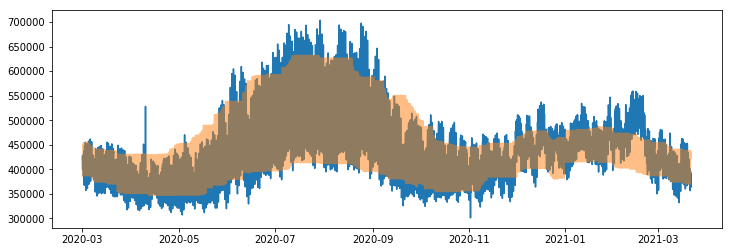

In [44]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(y_test.index, y_test)
ax.plot(y_test.index, best_preds_series, alpha=0.5)
plt.show()

In [45]:
def mean_abs_percent_error(y_test, y_pred):
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    return np.mean(np.abs((y_test - y_pred)/y_test)) * 100

In [46]:
mean_abs_percent_error(y_test, best_preds)

5.564861747767956

In [47]:
from xgboost import plot_importance, plot_tree

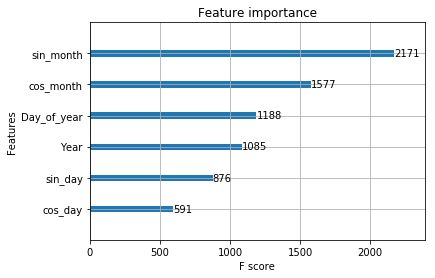

In [48]:
plot_importance(xgb_best)